# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.


## Task 1: Dependencies and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [ ]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

We'll need an OpenAI API Key:

In [8]:
import os
from dotenv import load_dotenv
import openai
from pathlib import Path
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Get the current working directory
current_dir = Path.cwd()

# Construct the path to the .env file
env_path = current_dir.parent.parent / '.env'

# Check if the .env file exists
if env_path.exists():
    logger.info(f".env file found at: {env_path}")
    # Load environment variables from .env file
    load_dotenv(dotenv_path=env_path)
else:
    logger.error(f".env file not found at: {env_path}")

# Retrieve the OpenAI API key from environment variables
openai.api_key = os.getenv("OPENAI_API_KEY")

# Verify that the API key is set
if openai.api_key:
    logger.info("OpenAI API key loaded successfully.")
else:
    logger.error("Failed to load OpenAI API key.")

INFO:__main__:.env file found at: c:\src\mlops\sb-aie4\.env
INFO:__main__:OpenAI API key loaded successfully.


And the LangSmith set-up:

In [9]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Week 8 Assignment 1 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"


Let's verify our project so we can leverage it in LangSmith later.

In [10]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Week 8 Assignment 1 - 748cc6f6


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

In [4]:
from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [16]:
# Replace the Google Colab file upload with a local file path
file_path = "MuskComplaint.pdf"  # Update this with the actual path to your PDF file

# Verify the file exists
import os
if os.path.exists(file_path):
    print(f"File found: {file_path}")
else:
    print(f"File not found: {file_path}")
    raise FileNotFoundError(f"The file {file_path} does not exist. Please provide a valid file path.")

# Import necessary modules
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

# Load and process the document
Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

print(f"Number of document chunks: {len(docs)}")

File found: MuskComplaint.pdf
Number of document chunks: 119


In [21]:
# Define the file path directly
file_path = "MuskComplaint.pdf"  # Update this with the actual path to your PDF file

# Verify the file exists
import os
if os.path.exists(file_path):
    print(f"File found: {file_path}")
else:
    print(f"File not found: {file_path}")
    raise FileNotFoundError(f"The file {file_path} does not exist. Please provide a valid file path.")

# Print the file path
print(file_path)

File found: MuskComplaint.pdf
MuskComplaint.pdf


We'll define our chunking strategy.

In [22]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [23]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [24]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

### Limitations I see in this approach:

1. **Memory and storage constraints:** The LocalFileStore cache and in-memory Qdrant client could consume significant resources, especially for larger datasets.

2. **Lack of persistence:** Since we're using an in-memory database (":memory:"), all data will be lost when the process ends. This isn't ideal for long-running applications.

3. **Potential for stale data:** If our underlying data or embedding model changes, the cache might become outdated, leading to inaccurate results.

### When I think this is most useful:

1. **Repeated queries:** This setup shines in scenarios where we're making frequent, similar queries on the same dataset. The caching really pays off here.

2. **Development and testing:** During the development phase, this approach can significantly speed up our iteration cycles.

3. **Cost optimization:** By reducing API calls to OpenAI for embeddings, we can potentially lower our operational costs.

### When I believe this is least useful:

1. **Large-scale production systems:** For very large datasets or high-concurrency environments, this single-machine, in-memory approach might not cut it.

2. **Frequently changing data:** If our document set is updated often, we'd lose a lot of the caching benefits and might even risk using outdated information.

3. **One-time analyses:** For scripts we only run occasionally, the overhead of setting up this caching system might not be worth the effort.

##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [25]:
import time
from langchain_openai import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain.embeddings import CacheBackedEmbeddings

# Set up the embeddings and cache
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Test texts
texts = [
    "This is a test sentence for embeddings.",
    "Another unique sentence for our experiment.",
    "This is a test sentence for embeddings.",  # Repeated intentionally
]

def run_embedding_test(embedder, texts):
    start_time = time.time()
    for text in texts:
        embedder.embed_query(text)
    end_time = time.time()
    return end_time - start_time

# Run tests
print("Testing with core embeddings (no cache):")
core_time = run_embedding_test(core_embeddings, texts)
print(f"Time taken: {core_time:.2f} seconds")

print("\nTesting with cached embeddings (first run, populating cache):")
first_cache_time = run_embedding_test(cached_embedder, texts)
print(f"Time taken: {first_cache_time:.2f} seconds")

print("\nTesting with cached embeddings (second run, using cache):")
second_cache_time = run_embedding_test(cached_embedder, texts)
print(f"Time taken: {second_cache_time:.2f} seconds")

# Calculate and print speedup
speedup = (core_time - second_cache_time) / core_time * 100
print(f"\nSpeedup with cache: {speedup:.2f}%")

# Check cache contents
cache_keys = list(store.yield_keys())
print(f"\nNumber of items in cache: {len(cache_keys)}")
print("First few cache keys:", cache_keys[:3] if len(cache_keys) > 3 else cache_keys)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Testing with core embeddings (no cache):


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Time taken: 0.54 seconds

Testing with cached embeddings (first run, populating cache):


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Time taken: 0.54 seconds

Testing with cached embeddings (second run, using cache):


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Time taken: 0.57 seconds

Speedup with cache: -5.04%

Number of items in cache: 120
First few cache keys: ['text-embedding-3-small006b0570-d38b-56d1-b4a1-c98df3d77d8f', 'text-embedding-3-small0266a3fd-f602-54ec-b850-e50b99c0e479', 'text-embedding-3-small0b435677-623e-5fee-861f-52d582aac2ae']


### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [26]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [27]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [28]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

### Limitations I see in this approach:

1. **Volatility:** The InMemoryCache is not persistent. Once the program terminates, all cached data is lost. This means we'd have to rebuild the cache from scratch on each restart.

2. **Memory constraints:** Since we're using an in-memory cache, we're limited by the available RAM. For applications dealing with a large number of unique queries, this could potentially lead to high memory usage or even out-of-memory errors.

3. **Lack of sharing:** This cache is local to the current process. In a distributed or multi-process environment, each instance would have its own separate cache, potentially leading to redundant LLM calls across the system.

### When I think this is most useful:

1. **Development and testing:** During the development phase, this approach can significantly speed up our iteration cycles by reducing repeated API calls to the LLM.

2. **Short-lived applications:** For scripts or applications that run for a limited time and don't need to persist data between runs, this in-memory cache can provide quick performance benefits without the overhead of setting up a more complex caching system.

3. **Repetitive queries:** In scenarios where we expect many identical queries within a single session, this cache can dramatically reduce response times and API costs.

### When I believe this is least useful:

1. **Long-running production services:** For services that need to maintain state across restarts or have high uptime requirements, the volatility of this cache could be problematic.

2. **Distributed systems:** In a distributed environment, where multiple instances of the application are running, this local cache wouldn't provide benefits across different instances.

3. **Applications with highly varied inputs:** If each query to the LLM is likely to be unique, we won't get much benefit from caching, and we might just be adding unnecessary complexity and memory usage to our application.

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [29]:
import time
from langchain_openai import ChatOpenAI
from langchain_core.caches import InMemoryCache
from langchain_core.globals import set_llm_cache



# Initialize the ChatOpenAI model
llm = ChatOpenAI(temperature=0)

# Test prompts
prompts = [
    "What is the capital of France?",
    "Who wrote 'Romeo and Juliet'?",
    "What is the capital of France?",  # Repeated intentionally
    "What is the boiling point of water in Celsius?",
    "Who wrote 'Romeo and Juliet'?",  # Repeated intentionally
]

def run_llm_test(llm, prompts):
    start_time = time.time()
    for prompt in prompts:
        response = llm.invoke(prompt)
        print(f"Prompt: {prompt}")
        print(f"Response: {response.content}")
        print("---")
    end_time = time.time()
    return end_time - start_time

# Run tests
print("First run (populating cache):")
first_run_time = run_llm_test(llm, prompts)
print(f"Time taken: {first_run_time:.2f} seconds\n")

print("Second run (using cache):")
second_run_time = run_llm_test(llm, prompts)
print(f"Time taken: {second_run_time:.2f} seconds\n")

# Calculate and print speedup
speedup = (first_run_time - second_run_time) / first_run_time * 100
print(f"Speedup with cache: {speedup:.2f}%")

# Check cache hits (this is a bit tricky with InMemoryCache, but we can infer from time)
cache_hits = sum(prompts.count(prompt) - 1 for prompt in set(prompts))
print(f"\nEstimated cache hits: {cache_hits}")

First run (populating cache):


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Prompt: What is the capital of France?
Response: The capital of France is Paris.
---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Prompt: Who wrote 'Romeo and Juliet'?
Response: William Shakespeare wrote "Romeo and Juliet".
---
Prompt: What is the capital of France?
Response: The capital of France is Paris.
---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Prompt: What is the boiling point of water in Celsius?
Response: The boiling point of water in Celsius is 100 degrees.
---
Prompt: Who wrote 'Romeo and Juliet'?
Response: William Shakespeare wrote "Romeo and Juliet".
---
Time taken: 1.46 seconds

Second run (using cache):
Prompt: What is the capital of France?
Response: The capital of France is Paris.
---
Prompt: Who wrote 'Romeo and Juliet'?
Response: William Shakespeare wrote "Romeo and Juliet".
---
Prompt: What is the capital of France?
Response: The capital of France is Paris.
---
Prompt: What is the boiling point of water in Celsius?
Response: The boiling point of water in Celsius is 100 degrees.
---
Prompt: Who wrote 'Romeo and Juliet'?
Response: William Shakespeare wrote "Romeo and Juliet".
---
Time taken: 0.00 seconds

Speedup with cache: 99.93%

Estimated cache hits: 2


## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [30]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [31]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AIMessage(content='Here are 50 things about the document "MuskComplaint.pdf":\n\n1. The document is a PDF file with a total of 46 pages.\n2. It is formatted in PDF 1.7.\n3. The document appears to be a legal complaint.\n4. The source of the document is labeled as \'source_104\', \'source_55\', and \'source_109\'.\n5. The document includes multiple exhibits.\n6. Page 35 contains the content labeled as "Exhibit 1."\n7. Page 18 discusses the impact of OpenAI’s models.\n8. The document mentions a significant model called GPT-3.\n9. GPT-3 reportedly uses 175 billion parameters.\n10. This parameter count is ten times that of any previous non-sparse language model.\n11. The document references the publication of research papers by OpenAI.\n12. The papers are intended to allow others to build on OpenAI\'s work.\n13. Page 37 includes a date stamp of December 8, 2015.\n14. The document refers to an incorporator named Jonathan Levy.\n15. Jonathan Levy is associated with a mailing address in Mount

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

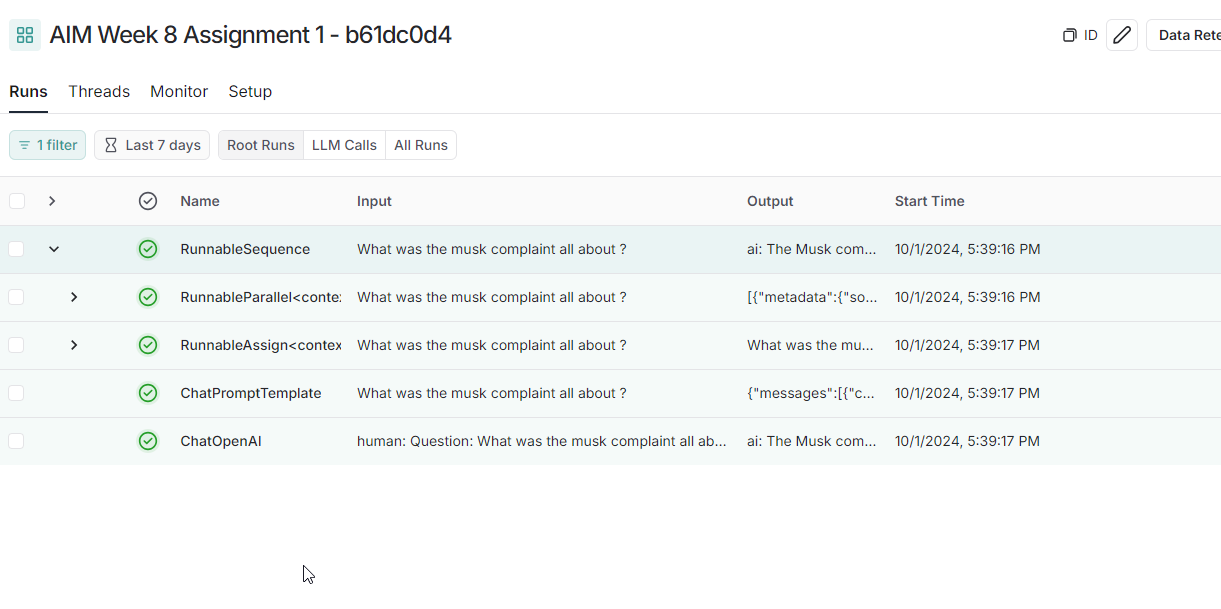